In [1]:
import matplotlib.pyplot as plt
from skimage import color, io, exposure
import cv2

In [2]:
from config import get_arguments
from SinGAN.manipulate import *
from SinGAN.training import *
from SinGAN.imresize import imresize
from SinGAN.imresize import imresize_to_shape
import SinGAN.functions as functions

In [3]:
in_video_path = "/home/vajira/simula/data/R_1004_11.02.03_1_HH.avi"
out_video_path = "/home/vajira/simula/data/sample_out_1.avi"

In [4]:
parser = get_arguments()
parser.add_argument('--input_dir', help='input image dir', default='Input/Images')
parser.add_argument('--input_name', help='training image name', required=False, default="dot_mask_new_3ch.png") # added default by vajira
parser.add_argument('--ref_dir', help='input reference dir', default='Input/Paint')
parser.add_argument('--ref_name', help='reference image name', required=False, default="sperm_6_3ch_gray.png")
parser.add_argument('--paint_start_scale', help='paint injection scale', type=int, required=False, default=3) # added default by vajira
parser.add_argument('--quantization_flag', help='specify if to perform color quantization training', type=bool, default=False)
parser.add_argument('--mode', help='task to be done', default='paint2image')
opt = parser.parse_args("")

In [5]:
opt

Namespace(Dsteps=3, Gsteps=3, alpha=10, beta1=0.5, gamma=0.1, input_dir='Input/Images', input_name='dot_mask_new_3ch.png', ker_size=3, lambda_grad=0.1, lr_d=0.0005, lr_g=0.0005, manualSeed=None, max_size=250, min_nfc=32, min_size=25, mode='paint2image', nc_im=3, nc_z=3, netD='', netG='', nfc=32, niter=2000, noise_amp=0.1, not_cuda=0, num_layer=5, out='Output', padd_size=0, paint_start_scale=3, quantization_flag=False, ref_dir='Input/Paint', ref_name='sperm_6_3ch_gray.png', scale_factor=0.75, stride=1)

In [6]:
def convert_single_frame_to_paint(frame, opt, real):
    #opt = functions.post_config(opt)
    #Gs = []
    #Zs = []
    #reals = []
    #NoiseAmp = []
    #dir2save = functions.generate_dir2save(opt)

    #real = functions.read_image(opt)
    #real = functions.adjust_scales2image(real, opt)
    #Gs, Zs, reals, NoiseAmp = functions.load_trained_pyramid(opt)

    # Handle Ref::
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_3ch = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    ref = functions.np2torch(gray_3ch, opt)
    ref = ref[:,0:3,:,:]

    if ref.shape[3] != real.shape[3]:
        ref = imresize_to_shape(ref, [real.shape[2], real.shape[3]], opt)
        ref = ref[:, :, :real.shape[2], :real.shape[3]]

    N = len(reals) - 1
    n = opt.paint_start_scale
    in_s = imresize(ref, pow(opt.scale_factor, (N - n + 1)), opt)
    in_s = in_s[:, :, :reals[n - 1].shape[2], :reals[n - 1].shape[3]]
    in_s = imresize(in_s, 1 / opt.scale_factor, opt)
    in_s = in_s[:, :, :reals[n].shape[2], :reals[n].shape[3]]

    out = SinGAN_generate(Gs[n:], Zs[n:], reals, NoiseAmp[n:], opt, in_s, n=n, num_samples=1)
    np_out = functions.convert_image_np(out.detach())
    
    #plt.imshow(np_out)
    #print(np_out)
    return np_out

    




In [7]:
opt = functions.post_config(opt)
Gs = []
Zs = []
reals = []
NoiseAmp = []
dir2save = functions.generate_dir2save(opt)

Random Seed:  6514


In [8]:
real = functions.read_image(opt)
real = functions.adjust_scales2image(real, opt)
Gs, Zs, reals, NoiseAmp = functions.load_trained_pyramid(opt)

X shape= (1562, 2090, 3)
x after imread=== (1562, 2090, 3)


In [18]:
def track_sperm(video_path, number_of_frames, out_video_path, track_scale=1):
    
    cap = cv2.VideoCapture(video_path)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(out_video_path, fourcc, 20.0, (800,598))

    # Model loading
    

    



    for i in range(number_of_frames):

        ret, frame = cap.read()

        out_frame = convert_single_frame_to_paint(frame, opt, real)

        # rescaling for video
        scale_percent = 320 # percent of original size
        width = int(out_frame.shape[1] * scale_percent / 100)
        height = int(out_frame.shape[0] * scale_percent / 100)
        dim = (width, height)
  
        # resize image
        out_frame = cv2.resize(out_frame, dim, interpolation = cv2.INTER_AREA)

        print(out_frame.shape)
        out_frame = out_frame * 255

        out.write(np.uint8(out_frame))

        plt.imshow(out_frame)

        #break
   
    cap.release()
    out.release()
    print("check pass")


In [19]:
#plt.imshow(out_frame)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(598, 800, 3)
(598, 800, 3)
(598, 800, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(598, 800, 3)
(598, 800, 3)
(598, 800, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid ran

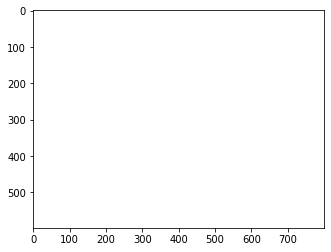

In [20]:
track_sperm(in_video_path, 10, out_video_path)